# Лабораторная работа 8

### Вариант 13

Аминов С.С.
М8О-408Б-19

Целью работы является исследование свойств некоторых динамических нейронных сетей, алгоритмов обучения, а также применение сетей в задаче распознавания динамических образов.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from collections import deque
import tqdm

Зададим управляющий сигнал

In [14]:
def u(k):
    return np.sin(k**2 - 2*k + np.pi)/7

In [15]:
N = 500
t = np.linspace(0, 5, N)

x = u(t)
y = [0]
for i in range(len(t) - 1):
    y.append(y[-1] / (1 + y[-1]**2) + x[i])

y = np.array(y)
assert x.shape == y.shape

Сгенерируем датасет

In [16]:
def gen_dataset(x, y, delay=5):
    return [(
        np.array(x[i:i+delay], dtype=np.float32),
        np.array(y[i+delay], dtype=np.float32)
     ) for i in range(len(x) - delay)]

In [17]:
train_data = gen_dataset(x, y)

In [18]:
data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)

Реализуем вспомогательный слой TDL и сеть NARX.

In [19]:
class TDL(nn.Module):
    def __init__(self, in_features, delay=1):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.delay = delay
        self.line = deque()
        self.clear()
    
    def clear(self):
        self.line.clear()
        for i in range(self.delay):
            self.line.append(torch.zeros(self.in_features))
    
    def push(self, input):
        self.line.appendleft(input)
    
    def forward(self, input=None):
        return self.line.pop()

In [20]:
class NARX(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, delay1, delay2):
        super(NARX, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.out_features = out_features

        self.line1 = TDL(in_features, delay1)
        self.line2 = TDL(out_features, delay2)

        self.w1 = torch.nn.Parameter(torch.randn(in_features, hidden_features))
        self.w2 = torch.nn.Parameter(torch.randn(hidden_features, out_features))
        self.w3 = torch.nn.Parameter(torch.randn(out_features, hidden_features))

        self.b1 = torch.nn.Parameter(torch.randn(hidden_features))
        self.b2 = torch.nn.Parameter(torch.randn(out_features))

    def clear(self):
        self.line1.clear()
        self.line2.clear()
    
    def forward(self, input):
        res = torch.tanh(
            self.line1() @ self.w1 + self.line2() @ self.w3 + self.b1
        ) @ self.w2 + self.b2
        self.line1.push(input.clone().detach()) # сохранять будем копии
        self.line2.push(res.clone().detach())
        return res

In [21]:
model = NARX(5, 10, 1, 3, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 40

In [22]:
loss = []
model.train()
for epoch in tqdm.tqdm(range(epochs)):
    epoch_loss = []
    for X_batch, y_batch in data_loader:
        y_pred = model(X_batch)
        cur_loss = criterion(y_batch, y_pred)
        epoch_loss.append(cur_loss.item())
        cur_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    loss += [np.mean(epoch_loss)]

  0%|                                                    | 0/40 [00:00<?, ?it/s]/home/magic/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████| 40/40 [00:09<00:00,  4.04it/s]


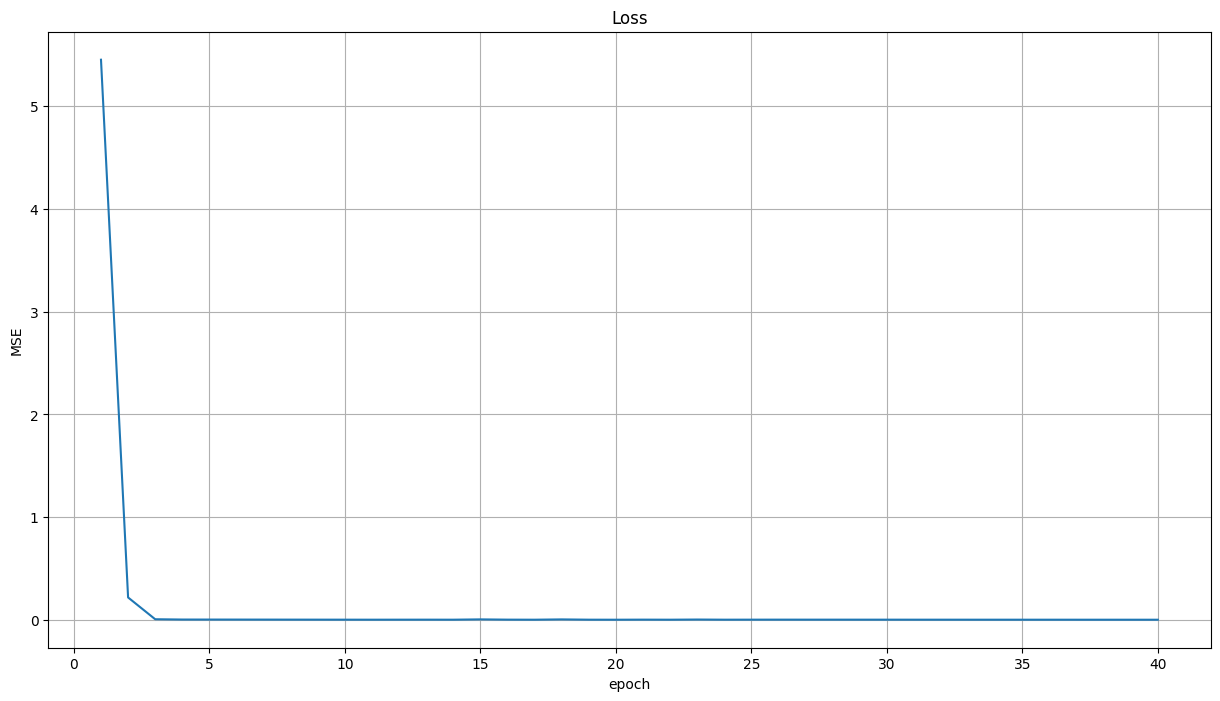

In [23]:
plt.figure(figsize=(15, 8))

plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, epochs+1), loss)
plt.title('Loss')
plt.grid()

plt.show()

In [24]:
model.eval()
model.clear()

preds = []
for X_batch, _ in data_loader:
    preds.append(model(X_batch).detach().numpy().item(-1))

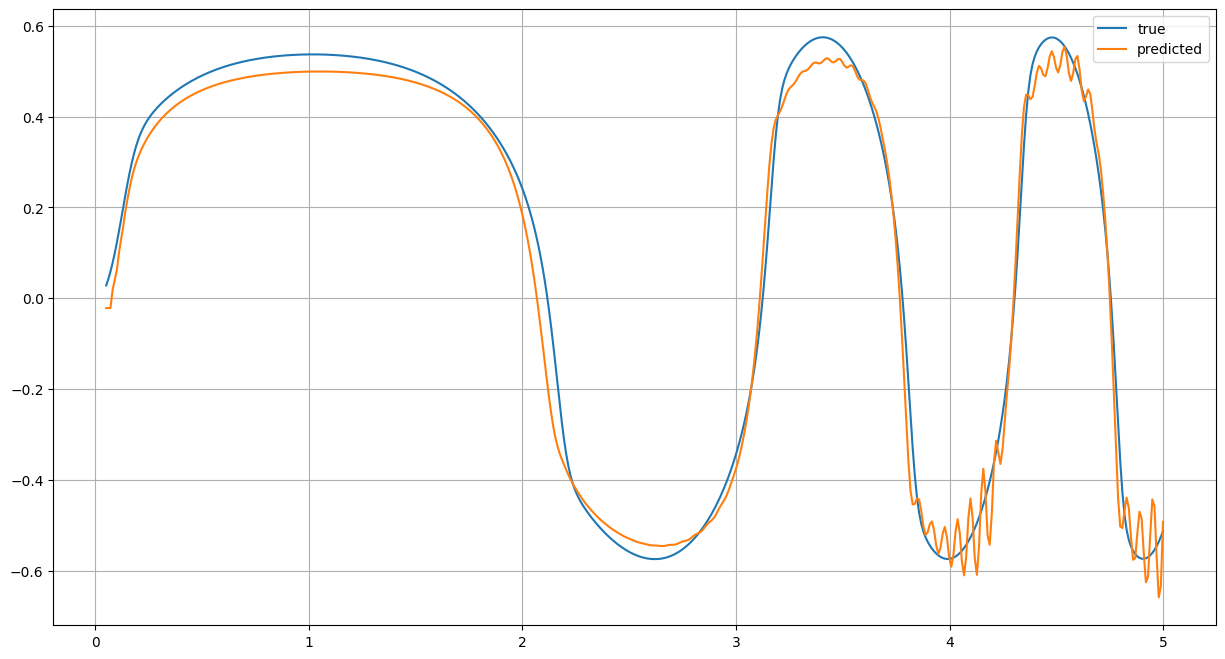

In [25]:
plt.figure(figsize=(15, 8))

plt.plot(t[5:], y[5:], label='true')
plt.plot(t[5:], preds, label='predicted')
plt.legend()
plt.grid()
plt.show()